In [1]:
import math
import numpy as np
import ceo
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
nLenslet = 1
n = 256
nPx = n*nLenslet+1
D = 25.5
n_radius = nPx
#onAxis = ceo.Source("R",zenith=0.*math.pi/180/3600,azimuth=0*math.pi/4,
#                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,-25])
src    = ceo.Source("R",zenith=0*60*math.pi/180/3600,azimuth=0*math.pi/4,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
GMT = ceo.GMT_MX(D,nPx)
wfs = ceo.ShackHartmann(1,nPx-1,D,N_PX_IMAGE=nPx)

In [3]:
sps = ceo.SegmentPistonSensor(GMT.M1,src)

In [4]:
M = sps.M[0]

In [9]:
[sps.M[k].nnz for k in range(12)]

[225, 253, 253, 225, 253, 253, 254, 225, 254, 254, 225, 254]

In [10]:
P = np.zeros((nPx,nPx))
for k in range(12):
    P += sps.M[k].f.host(shape=(nPx,nPx))

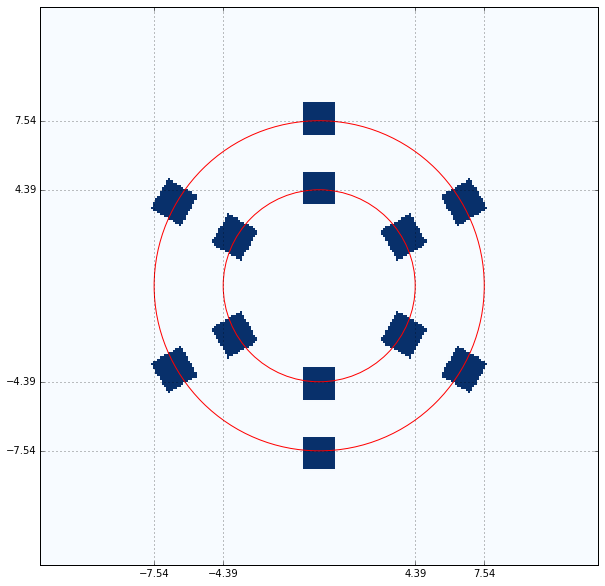

In [13]:
rc = 4.387
rp = 7.543
R = D/2
fig, ax1 = subplots()
fig.set_size_inches((10,10))
ax1.imshow(P,extent=[-R,R,-R,R],interpolation='None',cmap='Blues',origin='lower')
ax1.grid()
ax1.set_xticks([-rp,-rc,rc,rp])
ax1.set_yticks([-rp,-rc,rc,rp])
c1 = Circle((0,0),radius=rc, color='r', fill=False)
ax1.add_patch(c1)
c2 = Circle((0,0),radius=rp, color='r', fill=False)
ax1.add_patch(c2)

In [8]:
sps.M